# Exploring `cactice`

This notebook demonstrates basic `cactice` usage and explores some use cases.

## Reading data into `cactice`

First we review the formats `cactice` supports and demonstrate how to read some sample data. `cactice` currently supports 2 formats:

- comma- or tab-delimited data (CSV/TSV)
- text grids (2D character arrays)

### CSV files

`cactice` can read 1 or more grids from a CSV or TSV file containing columns for:

- grid index
- class label
- row index
- column index

By default `cactice` expects to find columns named `Grid`, `Class`, `I`, and `J`, respectively. Alternative mappings can also be provided. Note that the file *must* begin with a header row.

For instance, to read in some sample grids from a CSV file:

In [1]:
from typing import Dict

import numpy as np

from cactice.fileio import read_grids_csv

grids: Dict[str, np.ndarray] = read_grids_csv('../testdata/grids.csv')

### Text files

`cactice` can also read a single grid from a text file. The text is interpreted as a 2-dimensional character array, with newlines delimiting rows and each distinct character a class.

For instance:

In [2]:
from cactice.fileio import read_grid_txt

grids['from_text'] = read_grid_txt('../testdata/grid.txt')

## Plotting grids

Now that we've loaded some grids into `cactice` we can take a look at them.

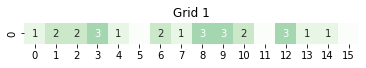

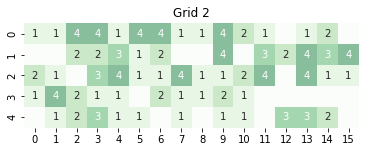

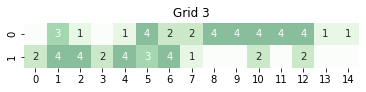

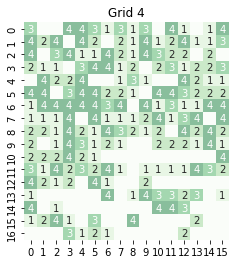

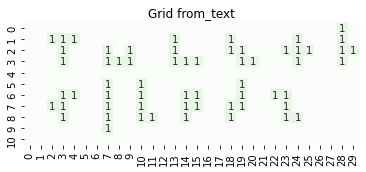

In [3]:
from cactice.plot import plot_grid

for name, grid in grids.items():
    plot_grid(grid, f"Grid {name}")

## Computing summary statistics

### Cell distribution

Now we'll calculate the grid cell class distribution overall and on a per-grid basis.

Grid 3 cell distribution:
{1: 0.2947, 2: 0.2579, 3: 0.1421, 4: 0.3053}


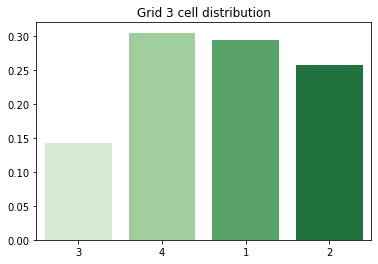

In [4]:
from pprint import pprint

from cactice.grids import cell_value_distribution
from cactice.plot import plot_cell_dist

grid = list(grids.values())[3]
cell_dist = cell_value_distribution([grid], exclude_zero=True)

title = f"Grid 3 cell distribution"
print(f"{title}:")
pprint(cell_dist)
plot_cell_dist(cell_dist, title)

### Bond distribution

We can also take a look at the distribution of bonds (adjacencies) between grid cell classes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 3 undirected bonds (horizontal):
{(1, 1): 0.0681818182,
 (1, 2): 0.1666666667,
 (1, 3): 0.0909090909,
 (1, 4): 0.1666666667,
 (2, 2): 0.0681818182,
 (2, 3): 0.0984848485,
 (2, 4): 0.1287878788,
 (3, 3): 0.0,
 (3, 4): 0.0909090909,
 (4, 4): 0.1212121212}


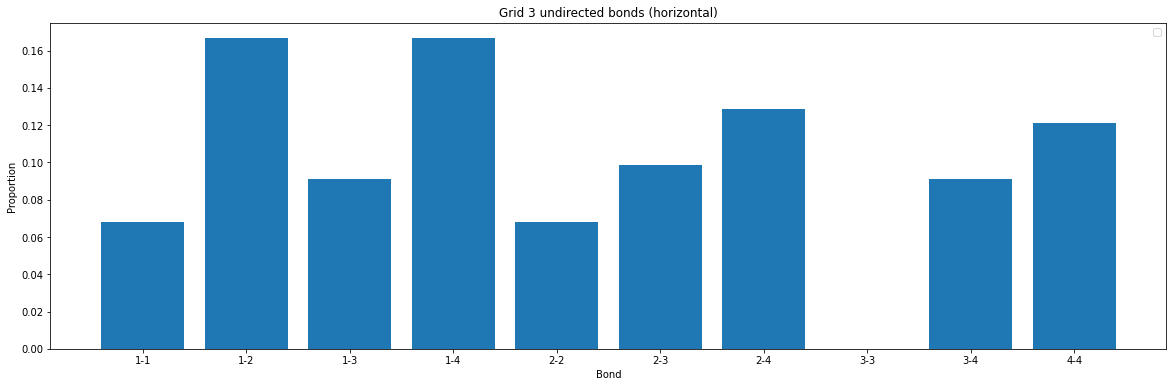

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 3 undirected bonds (vertical):
{(1, 1): 0.085106383,
 (1, 2): 0.1560283688,
 (1, 3): 0.0992907801,
 (1, 4): 0.1843971631,
 (2, 2): 0.0780141844,
 (2, 3): 0.0709219858,
 (2, 4): 0.1418439716,
 (3, 3): 0.0070921986,
 (3, 4): 0.0992907801,
 (4, 4): 0.0780141844}


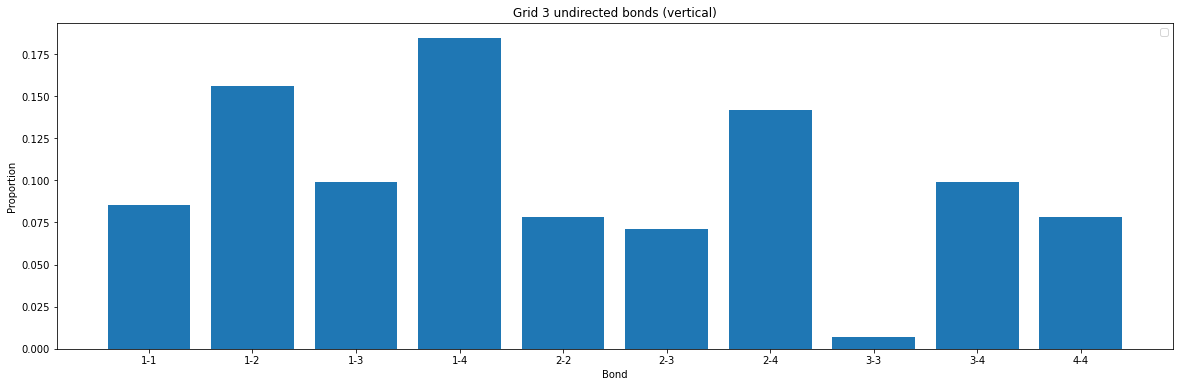

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 3 undirected bonds (combined):
{(1, 1): 0.07664410059999999,
 (1, 2): 0.16134751775,
 (1, 3): 0.09509993550000001,
 (1, 4): 0.1755319149,
 (2, 2): 0.07309800129999999,
 (2, 3): 0.08470341715,
 (2, 4): 0.13531592520000002,
 (3, 3): 0.0035460993,
 (3, 4): 0.09509993550000001,
 (4, 4): 0.0996131528}


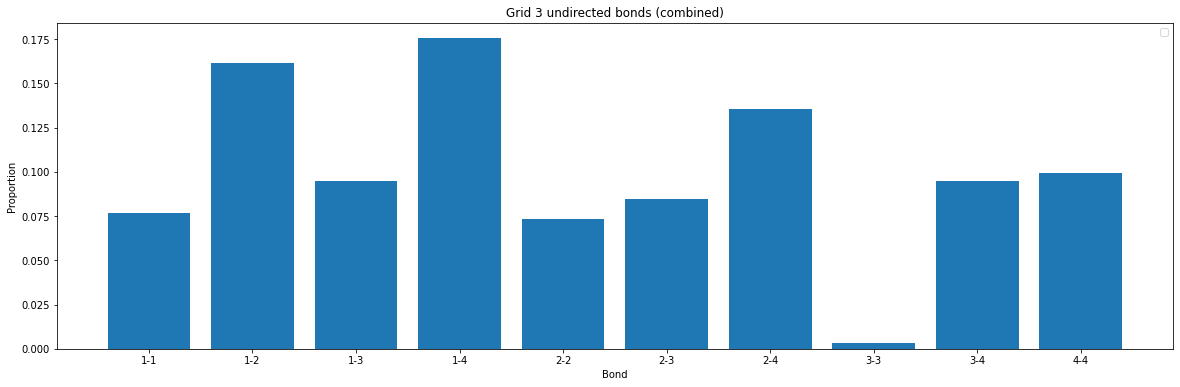

In [5]:
from cactice.grids import undirected_bond_distribution
from cactice.plot import plot_undirected_bond_dist

bonds_h, bonds_v = undirected_bond_distribution([grid], exclude_zero=True)

title = "Grid 3 undirected bonds (horizontal)"
print(f"{title}:")
pprint(bonds_h)
plot_undirected_bond_dist(bonds_h, title)

title = "Grid 3 undirected bonds (vertical)"
print(f"{title}:")
pprint(bonds_v)
plot_undirected_bond_dist(bonds_v, title)

bond_dist = {k: ((v + bonds_v[k]) / 2) for k, v in bonds_h.items()}

title = "Grid 3 undirected bonds (combined)"
print(f"{title}:")
pprint(bond_dist)
plot_undirected_bond_dist(bond_dist, title)

## Testing for spatial correlations

It's natural to ask whether there is any structure in the spatial distribution of phenotypes. If so, at what scale is it most apparent? To answer questions like this we can introduce a few utility methods on grids:

- `get_neighborhood`
- `get_neighborhoods`
- `get_band`
- `get_bands`

### Neighborhoods and bands

We can consider both `get_neighborhood` and `get_band` as operations that accept a given grid cell and return a set of zero or more other grid cells. These two functions can be combined to test for evidence of spatial correlations. The `get_bands ` and `get_neighborhoods` functions returns bands and neighborhoods (respectively) for all cells in a given grid, in a dictionary mapping relative or absolute location of the cell to its neighbor cells or band cells.

#### Neighborhoods

The neighborhood around a given cell is the set of adjacent cells. `cactice` supports cardinal neighbors (top/bottom/left/right), diagonal neighbors (topleft, topright, bottomleft, bottomright), and complete neighborhoods (the union of cardinal & diagonal, all 8 adjacent cells).

For instance, to compute the complete neighborhood around a grid cell:

{(4, 7): 1,
 (4, 8): 3,
 (4, 9): 1,
 (5, 7): 2,
 (5, 9): 0,
 (6, 7): 4,
 (6, 8): 0,
 (6, 9): 4}


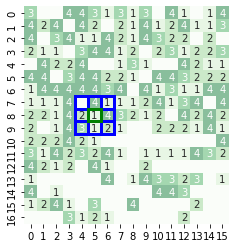

In [6]:
from matplotlib.patches import Rectangle
from cactice.grids import Neighbors, get_neighborhood

cell = (5, 8)  # cell location
neighbors = get_neighborhood(
    grid=grid,
    i=cell[0],
    j=cell[1],
    neighbors=Neighbors.COMPLETE,
    absolute_coords=True)

pprint(neighbors)
patches = [Rectangle((loc[0], loc[1]), 1, 1, fill=False, edgecolor='blue', lw=3) for loc in neighbors.keys()]
patches.append(Rectangle((cell[0], cell[1]), 1, 1, fill=False, edgecolor='green', lw=3))
plot_grid(grid, patches=patches)

To compute all neighborhoods in a given grid:

In [7]:
from itertools import islice
from cactice.grids import get_neighborhoods

# get neighborhoods for all cells in the grid
neighborhoods = get_neighborhoods(
    grid=grid,
    neighbors=Neighbors.COMPLETE,
    absolute_coords=True)

print(f"First 5 neighborhoods:")
pprint(dict(islice(neighborhoods.items(), 5)))

First 5 neighborhoods:
{(0, 0): {(0, 1): 0, (1, 0): 4, (1, 1): 2},
 (0, 1): {(0, 0): 3, (0, 2): 0, (1, 0): 4, (1, 1): 2, (1, 2): 4},
 (0, 2): {(0, 1): 0, (0, 3): 4, (1, 1): 2, (1, 2): 4, (1, 3): 0},
 (0, 3): {(0, 2): 0, (0, 4): 4, (1, 2): 4, (1, 3): 0, (1, 4): 4},
 (0, 4): {(0, 3): 4, (0, 5): 3, (1, 3): 0, (1, 4): 4, (1, 5): 2}}


#### Bands

A "band" around a given cell is a square "ring" of cells at a given integer radius `r` around it.

{(2, 5): 1,
 (2, 6): 4,
 (2, 7): 2,
 (2, 8): 1,
 (2, 9): 4,
 (2, 10): 3,
 (2, 11): 2,
 (3, 5): 4,
 (3, 11): 3,
 (4, 5): 0,
 (4, 11): 0,
 (5, 5): 4,
 (5, 11): 4,
 (6, 5): 4,
 (6, 11): 3,
 (7, 5): 4,
 (7, 11): 1,
 (8, 5): 1,
 (8, 6): 4,
 (8, 7): 3,
 (8, 8): 2,
 (8, 9): 1,
 (8, 10): 2,
 (8, 11): 0}


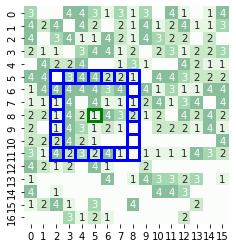

In [8]:
from cactice.grids import get_band

r = 3  # get the band of radius 3 around the given cell
band = get_band(
    grid=grid,
    i=cell[0],
    j=cell[1],
    radius=r,
    absolute_coords=True)

pprint(band)
patches = [Rectangle((loc[0], loc[1]), 1, 1, fill=False, edgecolor='blue', lw=3) for loc in band.keys()]
patches.append(Rectangle((cell[0], cell[1]), 1, 1, fill=False, edgecolor='green', lw=3))
plot_grid(grid, patches=patches)

#### Bins

A "bin" around a given cell is the set of all cells within some (Euclidean) distance range `[d_min, d_max]` from it.

{(1, 8): 1,
 (2, 6): 4,
 (2, 7): 2,
 (2, 8): 1,
 (2, 9): 4,
 (2, 10): 3,
 (3, 5): 4,
 (3, 6): 4,
 (3, 7): 1,
 (3, 8): 2,
 (3, 9): 0,
 (3, 10): 2,
 (3, 11): 3,
 (4, 5): 0,
 (4, 6): 0,
 (4, 10): 0,
 (4, 11): 0,
 (5, 4): 4,
 (5, 5): 4,
 (5, 6): 2,
 (5, 10): 4,
 (5, 11): 4,
 (5, 12): 3,
 (6, 5): 4,
 (6, 6): 3,
 (6, 10): 1,
 (6, 11): 3,
 (7, 5): 4,
 (7, 6): 1,
 (7, 7): 1,
 (7, 8): 1,
 (7, 9): 2,
 (7, 10): 4,
 (7, 11): 1,
 (8, 6): 4,
 (8, 7): 3,
 (8, 8): 2,
 (8, 9): 1,
 (8, 10): 2,
 (9, 8): 0}


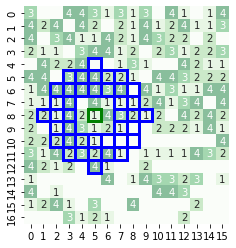

In [9]:
from cactice.grids import get_bin

d = (2, 4)       # get the bin from distance [2-4] around the cell
binn = get_bin(  # don't shadow built-in `bin`
    grid=grid,
    i=cell[0],
    j=cell[1],
    d_min=d[0],
    d_max=d[1],
    absolute_coords=True)

pprint(binn)
patches = [Rectangle((loc[0], loc[1]), 1, 1, fill=False, edgecolor='blue', lw=3) for loc in binn.keys()]
patches.append(Rectangle((cell[0], cell[1]), 1, 1, fill=False, edgecolor='green', lw=3))
plot_grid(grid, patches=patches)

### Testing for evidence of spatial correlation

First we can retrieve for each cell the band of cells displaced from it by radius `r=1`, then compute the Hamming distance between the central cell's neighborhood and the neighborhood of each band cell. We can then take a look at a heatmap of neighborhood similarity (larger values corresponding to lower distances & greater similarity).

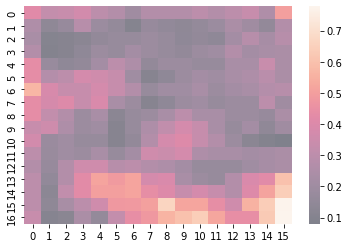

In [10]:
from cactice.grids import neighborhood_correlations

import seaborn as sns
import matplotlib.pyplot as plt

# first return value is dictionary, second is Numpy 2D-array
_, avg_dist_grid = neighborhood_correlations(grid, radius=1)

# invert the grid to obtain similarity rather than distance
sns.heatmap(1 - avg_dist_grid, alpha=0.5)
plt.show()

This seems to reflect the tendency in this grid for missing values to cluster together. To remove this artifact, we can repeat the above with zeroes (missing values) excluded.

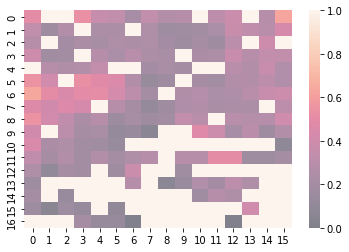

In [11]:
_, avg_dist_grid = neighborhood_correlations(grid, radius=1, exclude_zero=True)
sns.heatmap(1 - avg_dist_grid, alpha=0.5)
plt.show()

#### Neighborhood distributions

It's natural to ask whether a given location's class has any influence on its neighbors. To test this we can use a chi-squared test, comparing the proportion of classes in cell neighborhoods to an expectation value. If there is no correlation between a particular location's class and that of its neighbors, we would expect its neighbor distribution to match the overall class distribution.

The first step is to compute the transition matrix (i.e., count the number of adjancent bonds from each class to each class), then normalize by column to obtain the proportion of each bond from each class.

Transition frequencies:
array([[ 72.,  91.,  44.,  92.],
       [ 91.,  74.,  41.,  68.],
       [ 44.,  41.,  12.,  45.],
       [202., 159.,  93., 221.]])


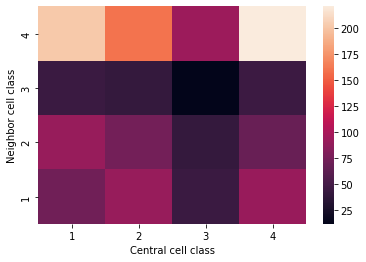

Transition proportions:
array([[0.17603912, 0.24931507, 0.23157895, 0.21596244],
       [0.22249389, 0.20273973, 0.21578947, 0.15962441],
       [0.10757946, 0.11232877, 0.06315789, 0.1056338 ],
       [0.49388753, 0.43561644, 0.48947368, 0.51877934]])


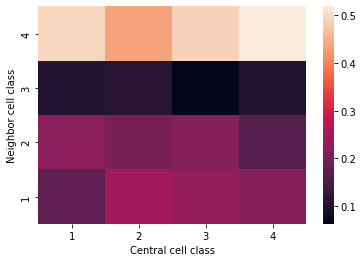

In [12]:
from cactice.grids import transition_matrix

transitions = transition_matrix(grid, neighbors=Neighbors.COMPLETE, exclude_zero=True)
trans_props = np.array([[val / sum(transitions[:,i]) for val in transitions[:,i]] for i in range(0, len(transitions))]).transpose()

print(f"Transition frequencies:")
pprint(transitions)
ax = sns.heatmap(
    transitions,
    xticklabels=[str(k + 1) for k in range(0, transitions.shape[0])],
    yticklabels=[str(k + 1) for k in range(0, transitions.shape[0])])
ax.set_ylabel('Neighbor cell class')
ax.set_xlabel('Central cell class')
ax.invert_yaxis()
plt.show()

print(f"Transition proportions:")
pprint(trans_props)
ax = sns.heatmap(
    trans_props,
    xticklabels=[str(k + 1) for k in range(0, transitions.shape[0])],
    yticklabels=[str(k + 1) for k in range(0, transitions.shape[0])])
ax.set_ylabel('Neighbor cell class')
ax.set_xlabel('Central cell class')
ax.invert_yaxis()
plt.show()

This is merely another way to represent and visualize the adjacency distribution explored above. The transition matrix is more amenable to various computations, however.

We can first take a look at the distribution of neighbors of each given cell class. If there is no spatial structure underlying neighborhood distributions, we expect that on average, the proportions of each class in a cell's neighborhood might match the observed adjacency distribution in the broader sample (in this case the grid). In other words, a given cell's class should tell us nothing about its neighbors except what we might guess from the overall transition proportions.

As a reminder, we can first look again at the grid's cell and adjacent bond distributions:

Grid 3 cell distribution:
{1: 0.2947, 2: 0.2579, 3: 0.1421, 4: 0.3053}


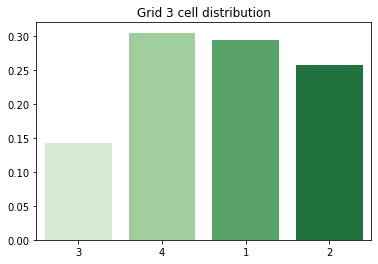

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Grid 3 undirected bonds (combined):
{(1, 1): 0.07664410059999999,
 (1, 2): 0.16134751775,
 (1, 3): 0.09509993550000001,
 (1, 4): 0.1755319149,
 (2, 2): 0.07309800129999999,
 (2, 3): 0.08470341715,
 (2, 4): 0.13531592520000002,
 (3, 3): 0.0035460993,
 (3, 4): 0.09509993550000001,
 (4, 4): 0.0996131528}


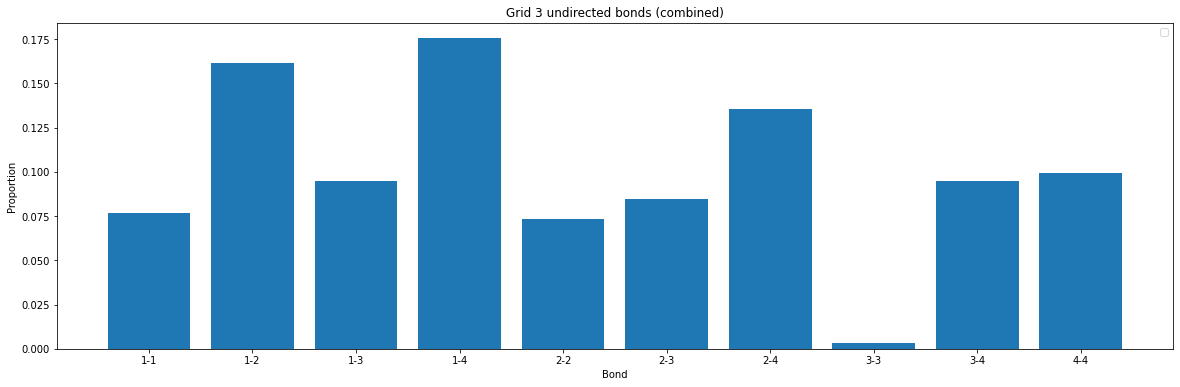

In [13]:
title = f"Grid 3 cell distribution"
print(f"{title}:")
pprint(cell_dist)
plot_cell_dist(cell_dist, title)

title = "Grid 3 undirected bonds (combined)"
print(f"{title}:")
pprint(bond_dist)
plot_undirected_bond_dist(bond_dist, title)

Now we can construct a dataframe compared observed neighborhoods distributions with our expectation.

/var/folders/bk/xk1_stdx6096p4_57slyjzgw0000gn/T/ipykernel_47467/243329422.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'type': 'expected', 'cell': ci + 1, 'neighbor': cj + 1, 'proportion': expected}, ignore_index=True)
/var/folders/bk/xk1_stdx6096p4_57slyjzgw0000gn/T/ipykernel_47467/243329422.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'type': 'observed', 'cell': ci + 1, 'neighbor': cj + 1, 'proportion': observed}, ignore_index=True)
/var/folders/bk/xk1_stdx6096p4_57slyjzgw0000gn/T/ipykernel_47467/243329422.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'type': 'expected', 'cell': ci + 1, 'neighbor': cj + 1, 'proportion': expected}, ignore_i

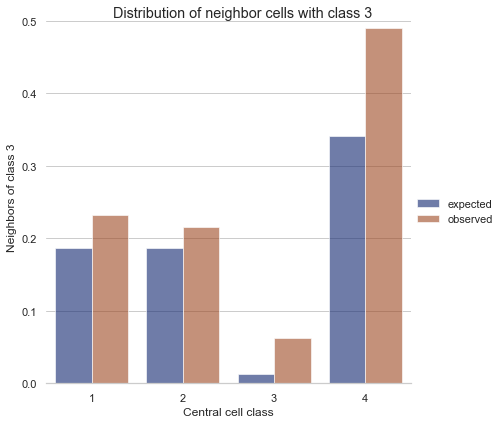

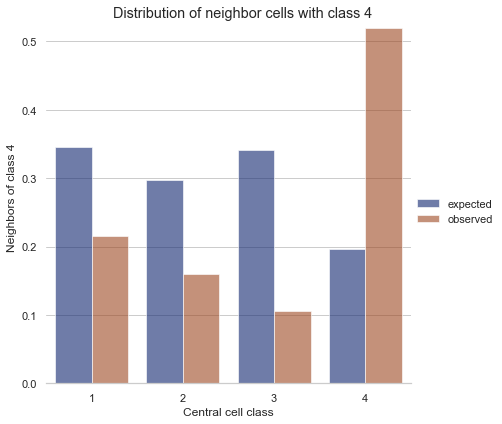

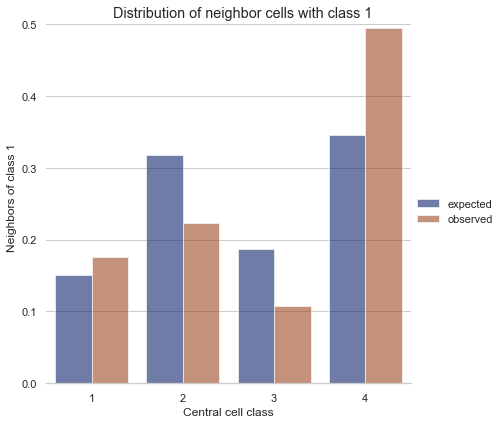

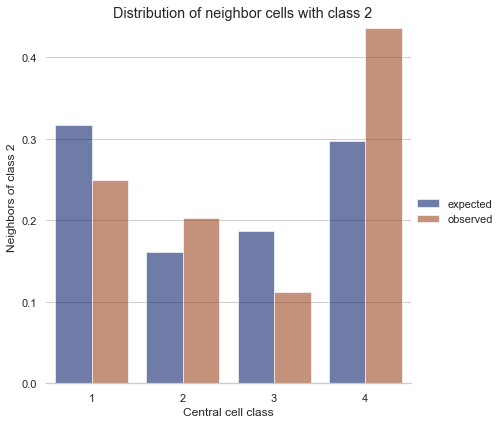

In [14]:
import pandas as pd

data = pd.DataFrame(columns=['type', 'cell', 'neighbor', 'proportion'])
for ci in range(0, len(trans_props)):
    for cj in range(0, len(trans_props)):
        ek = sorted([ci + 1, cj + 1])
        others = [bond_dist[min(ek[0], i), max(ek[0], i)] for i in range(1, len(trans_props) + 1)]
        expected = bond_dist[ek[0], ek[1]] / sum(others)
        observed = trans_props[ci, cj]
        data = data.append({'type': 'expected', 'cell': ci + 1, 'neighbor': cj + 1, 'proportion': expected}, ignore_index=True)
        data = data.append({'type': 'observed', 'cell': ci + 1, 'neighbor': cj + 1, 'proportion': observed}, ignore_index=True)

for cls in cell_dist.keys():
    sns.set_theme(style="whitegrid")
    # Draw a nested barplot by species and sex
    g = sns.catplot(
        data=data[data.neighbor==cls], kind="bar",
        x="cell", y='proportion', hue="type", ci=None,
        palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.figure.suptitle(f"Distribution of neighbor cells with class {cls}")
    g.set_axis_labels("Central cell class", f"Neighbors of class {cls}")
    g.legend.set_title("")

## Cell prediction

By default `cactice` interprets empty or zero-valued grid cells as missing values. Several methods for predicting missing cells given a known cell distribution are supported:

- random neighbor selection
- k-nearest neighbors
- bond energy minimization (via Metropolis algorithm)

These strategies can also be used to generate entirely novel grids. They follow the `numpy` and `scipy` conventions in exposing two primary methods, `fit()` and `predict()`.

### Random neighbor selection

The random neighbor selection strategy attempts to locate then select randomly from known neighbors of each unknown cell location: thus an unknown cell's neighbors "vote" to select its own value. If no neighbors are known, the cell's value is randomly selected according to the known class distribution.

A new random neighbor selection model can be created as such:

In [15]:
from cactice.rns import RNS
from cactice.grids import Neighbors

rns = RNS(neighbors=Neighbors.CARDINAL)

ModuleNotFoundError: No module named 'cactice.stats'

Next, fit the model on grids we've read into `cactice`:

In [ ]:
rns.fit(list(grids.values()))

Now impute missing cell locations on the multinomial training grids:

In [ ]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    imputed = rns.predict([grid])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(imputed, f"Grid {name} imputed (RNS)")

Random neighbor selection can also be used to predict entirely novel grids, but this is not suggested: it will tend simply to reproduce the training grids' cell class distribution without preserving any spatial information.

For instance:

In [ ]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    novel = np.zeros_like(grid).astype(int)
    novel = rns.predict([novel])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(novel, f"Grid {name} generated same-size (RNS)")

    # TODO demonstrate that class distribution is roughly equivalent while bond distribution is not?

### K-nearest neighbors

The k-nearest neighbors model attempts to predict cell values based on neighborhoods similar to the location to be predicted. Neighborhood similarity is evaluated by mapping each neighborhood to a fixed-length string, in which each neighboring location corresponds to a particular character, and computing the Hamming distance between strings. The algorithm then ranks neighborhoods according to similarity to the neighborhood of the cell to be predicted, retaining a small subset of the most similar neighborhoods, then selects the most common central cell value from the subset (ties are broken randomly).

In [ ]:
from cactice.knn import KNN
from cactice.grids import Neighbors

knn = KNN(k=10, neighbors=Neighbors.CARDINAL)

Fit the model on the grids we've loaded:

In [ ]:
knn.fit(list(grids.values()))

Now impute missing locations on the multinomial training grids:

In [ ]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    imputed = rns.predict([grid])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(imputed, f"Grid {name} imputed (KNN)")

KNN can also be used to generate entirely novel grids, but this is subject to the same limitation faced by RNS: when a cell has no known neighbors, the cell value is randomly selected according to the known class distribution (preserving no spatial information from the training set).

In [ ]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    novel = np.zeros_like(grid).astype(int)
    novel = knn.predict([novel])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(novel, f"Grid {name} generated same-size (KNN)")

    # TODO demonstrate that class distribution is roughly equivalent while bond distribution is not?

### Bond energy minimization

The bond energy minimization model takes inspiration from statistical physics, in particular spin lattices and associated Markov random field theory. "Bonds" between adjacent grid cells are assigned an energy proportional to the bond distribution in the training set; i.e., cell pairs rarely found adjacent to one another are associated with higher bond energy than frequent pairs. A Markov chain Monte Carlo method (namely the Metropolis algorithm) is then applied to minimize the total configuration energy (the sum of bond energies over the whole grid).

In [ ]:
from cactice.mrf import MRF
from cactice.grids import Neighbors

mrf = MRF(neighbors=Neighbors.CARDINAL,
          interaction='proportional',
          J=2.0,
          iterations=50,
          threshold=0.01)

Fit the model:

In [ ]:
mrf.fit(list(grids.values()))

Now impute the multinomial grids:

In [ ]:
for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    imputed = mrf.predict([grid])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(imputed, f"Grid {name} imputed (MRF)")

Bond energy minimization via MCMC sampling can also be used to generate novel grids. There is a danger, if the Metropolis algorithm is allowed to run too long, however, of overly homogeneous predictions. Since the objective function considers only the overall bond distribution, it will eventually converge to the maximum number possible of the most frequent bonds in the training set. This fails to capture larger spatial structures latent in the training data.

To obtain good results, the number of iterations may need to be tuned proportional to grid size. Note how the largest generated grid is much more plausible than the smallest (which seems much more regular than its real counterpart).

In [ ]:
mrf = MRF(neighbors=Neighbors.CARDINAL,
          interaction='proportional',
          J=2.0,
          iterations=50,
          threshold=0.01)

mrf.fit(list(grids.values()))

for name, grid in grids.items():
    if name == 'from_text': continue  # skip the binary tile grid
    novel = np.zeros_like(grid).astype(int)
    novel = mrf.predict([novel])[0]

    plot_grid(grid, f"Grid {name} original")
    plot_grid(novel, f"Grid {name} generated same-size (MRF)")

    # TODO demonstrate that both class distribution and bond distribution are similar?
    # this is why MRF is better for imputing sparser data and/or generating it de novo

## Cross-validation & metrics

TODO

## Finding tiles

`cactice` can search grids for "tiles" (contiguous regions) of a particular class. For instance, to find non-empty tiles (in this case consisting of `#` characters) in a binary grid:

In [ ]:
from cactice.tiles import find_tiles

tiles = find_tiles(grids['from_text'], target=1)
print("Tiles:")
pprint(tiles)